# stat 128 final project by Austin Wilson
- dataset from kaggle competition: https://www.kaggle.com/techsash/waste-classification-data
- there are two classes 
    - O stands for organic waste    
    - R stands for recyclable waste
- the purpose of this notebook
    - is to load this data into memory as a numpy array of 64 floating point numbers 
    - use the data to train a neural network to classify images as R or O 


In [4]:
import pandas as pd 
import numpy as np 
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [6]:
path_train = 'DATASET/TRAIN' 
path_test = 'DATASET/TEST'
path_to_model = '/models/'#'/Users/austinwilson/coding/r/final-project/waste-recognition/models/'
model_name = "test.hdf5"# 'model_simple4.hdf5'

## example of one organic waste image

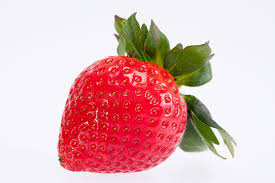

In [8]:
Image.open(path_train + "/O/O_10.jpg")

## example of one recyclable waste image

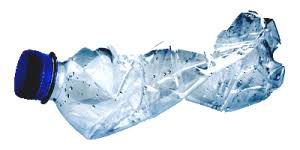

In [9]:
Image.open(path_train + "/R/R_10.jpg")

## this is a function that will convert all images to format that keras Sequential model can process
- the input path specifies the path to the data set which we will pass seperately for train and test data
- the input img_size is default 128 x 128 pixels, we did not modify this as to improve computation time
- the first two lines of the function will store all of the image names in a list to be traversed later
- the second two lines are the array that we will use to store the image data once converted into numerical format
- the for loops do the same thing for the organic images and recyclable images, respectively
    - the for loop loops through all images in the directory and converts them to numpy array and then stores them in the associated list
    - note that the command '.convert("RGB")' is to correct an error that occured from some images in greyscale 
    - note that 'if img.size == (128,128)' is just to ensure that all images were properly resized 

In [154]:
def get_numpy_image_array(path, img_size = (128,128)):
    image_names_o = os.listdir(path + "/O")
    image_names_r = os.listdir(path + "/R")
    numpy_img_array_o = []
    numpy_img_array_r = []

    # for the images in O category 
    for img_name in image_names_o:
        # some images in grey scale
        img = Image.open(path + "/O/" + img_name).convert("RGB")
        img = img.resize(img_size)
        img_array = np.asarray(img)
        if img.size == (128,128):
            numpy_img_array_o.append(img_array)

    # for the images in R category 
    for img_name in image_names_r:
        # some images in grey scale
        img = Image.open(path + "/R/" + img_name).convert("RGB")
        img = img.resize(img_size)
        img_array = np.asarray(img)
        if img.size == (128,128):
            numpy_img_array_r.append(img_array)



    return np.asarray(numpy_img_array_o, dtype="float64"), np.asarray(numpy_img_array_r, dtype="float64")

## getting images into a numpy array for training/test and organic/recycle

In [155]:

organic_images_train, recyclable_images_train = get_numpy_image_array(path_train)
organic_images_test, recyclable_images_test = get_numpy_image_array(path_test)

In [156]:
x_train = np.concatenate([organic_images_train,recyclable_images_train])
x_test = np.concatenate([organic_images_test,recyclable_images_test])

## building the associated set of labels for x_train and x_test

In [157]:
y_organic_train = np.repeat("O",len(organic_images_train))
y_recycle_train = np.repeat("R",len(recyclable_images_train))


In [158]:
y_organic_test = np.repeat("O",len(organic_images_test))
y_recycle_test = np.repeat("R",len(recyclable_images_test))

In [159]:
y_train = np.concatenate([y_organic_train,y_recycle_train])
y_test = np.concatenate([y_organic_test,y_recycle_test])

## creating label encoder for the values of O and R 
- not sure if I need two label encoders

In [160]:
le_1 = LabelEncoder()
y_train = le_1.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train)

le_2 = LabelEncoder()
y_test = le_2.fit_transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test)



## normalize the data

In [162]:
x_train = x_train / 255
x_test = x_test / 255

MemoryError: Unable to allocate 8.26 GiB for an array with shape (22564, 128, 128, 3) and data type float64

confirm size of all sets

In [163]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(22564, 128, 128, 3)
(22564, 2)
(2513, 128, 128, 3)
(2513, 2)


## simple model with one hidden layer
- this is the simplest model I will use just to ensure that the data is working

In [164]:
model_name = "simple_model.hdf5"
model_simple = Sequential()
model_simple.add(Dense(32,input_shape=(128,128,3),activation='relu'))
model_simple.add(Flatten())
model_simple.add(Dense(2,activation='softmax'))
model_simple.compile(loss='categorical_crossentropy',optimizer='adam')

In [165]:
# early stopping and checkpoint to save model weights

monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
checkpointer = ModelCheckpoint(filepath=path_to_model+model_name,verbose=0,save_best_only=True)


In [166]:
# training!!
for i in range(5):
    model_simple.fit(x_train ,y_train,
                    batch_size = 20,
                    epochs = 20,
                    verbose=2,
                    callbacks=[monitor, checkpointer],
                    validation_data=(x_test,y_test))



MemoryError: Unable to allocate 4.13 GiB for an array with shape (22564, 128, 128, 3) and data type float32

## predictions

In [167]:
y_true = np.argmax(y_test,axis = 1)
y_pred = model_simple.predict(x_test)
y_pred = np.argmax(y_pred,axis = 1)

In [ ]:
f1_simple = metrics.f1_score(y_true,y_pred,average='weighted')
print("F1 score:" + str(f1_simple))

In [ ]:
## classification report

In [120]:
report = metrics.classification_report(y_true,y_pred)
print(report)

NameError: name 'y_true' is not defined

## these models will not run on my computer (outsourcing to nerd friends with GPU)

## VGG19

In [ ]:
vgg19_128 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

model_19_128 = Sequential()
for layer in vgg19_128.layers:
  model_19_128.add(layer)
for layer in model_19_128.layers:
  layer.trainable = False


model_19_128.add(Flatten())
model_19_128.add(Dense(2,activation='softmax'))






In [ ]:
checkpointer_vgg19_128 = ModelCheckpoint(filepath=path_to_model + 'vgg19_1.hdf5',verbose=0,save_best_only=True)
monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
model_19_128.compile(optimizer='adam',loss='categorical_crossentropy')

In [ ]:


# for i in range(5):
model_19_128.fit(x_train,y_train,
            batch_size=32,
            epochs=20,
            verbose=2,
            callbacks=[monitor,checkpointer_vgg19_128],
            validation_data=(x_test,y_test))



In [ ]:
y_true = np.argmax(y_test,axis = 1)
y_pred = model_19_128.predict(x_test)
y_pred = np.argmax(y_pred,axis = 1)
f1_vgg19 = metrics.f1_score(y_true,y_pred,method="weighted")

## VGG16

## inception

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet = ResNet50(input_shape=(128, 128,3), include_top=False, weights="imagenet")

In [114]:
# import efficientnet.keras as efn

In [115]:
# efficientnet = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')